# scATAC -> Multiome Label Transfer

scATAC -> Multiome ATAC label transfer.

In [1]:
library(Matrix)
library(ggplot2)
library(patchwork)
library(GenomicRanges)
library(scales)
library(RColorBrewer)
library(DESeq2)
library(rtracklayer)
library(Seurat)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading

## Loading Inputs

### MetaData

In [2]:
# Metadata file for scATAC
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
scatac_only_metaData = read.table("../20200206_pmat_snapATAC/sessions/20210717_n62599/metadata.tsv", header = T)
rownames(scatac_only_metaData) = paste(scatac_only_metaData$sample, scatac_only_metaData$barcode, sep='_')
scatac_only_metaData$cells = rownames(scatac_only_metaData)
scatac_only_metaData = scatac_only_metaData[scatac_only_metaData$sample=="D2", ]
rownames(scatac_only_metaData) = scatac_only_metaData$barcode
dim(scatac_only_metaData)
head(scatac_only_metaData, 5)

[1] 6559    6

,barcode,sample,umap1,umap2,cluster,cells
,<fct>,<fct>,<dbl>,<dbl>,<int>,<chr>
AAACAACGAGAAGTTA,AAACAACGAGAAGTTA,D2,-2.582804,1.0539784,10,D2_AAACAACGAGAAGTTA
AAACAACGAGACTGTT,AAACAACGAGACTGTT,D2,-3.609249,0.2938383,15,D2_AAACAACGAGACTGTT
AAACCCTGAGTACGTT,AAACCCTGAGTACGTT,D2,-3.560982,-6.2913636,13,D2_AAACCCTGAGTACGTT
AAACCGTACCACCTAA,AAACCGTACCACCTAA,D2,-2.479006,-3.8390841,3,D2_AAACCGTACCACCTAA
AAACCGTACGCCCTAG,AAACCGTACGCCCTAG,D2,-3.901256,0.8696430,15,D2_AAACCGTACGCCCTAG


In [3]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20220609_Multiome_SnapATAC/sessions/20220612_n13525/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 13525    11

,barcode,TN,UM,PP,UQ,CM,cluster,umap1,umap2,sample,cells
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<chr>
D1M_AAAAAAAAAAACATGCTATTAGCC,AAAAAAAAAAACATGCTATTAGCC,6736,6736,6736,6729,373,3,-0.4031222,-3.454888,D1M,D1M_AAAAAAAAAAACATGCTATTAGCC
D1M_AAAAAAAAAAACATGCTCACCCTC,AAAAAAAAAAACATGCTCACCCTC,28369,28369,28369,28339,2447,5,2.6643078,-3.955240,D1M,D1M_AAAAAAAAAAACATGCTCACCCTC
D1M_AAAAAAAAAAACATGCTTGAGAAC,AAAAAAAAAAACATGCTTGAGAAC,28635,28635,28635,28609,2201,1,-0.2071755,2.688192,D1M,D1M_AAAAAAAAAAACATGCTTGAGAAC
D1M_AAAAAAAAAAACCATGAACCTTGT,AAAAAAAAAAACCATGAACCTTGT,33869,33869,33869,33838,3018,5,3.1269215,-4.609105,D1M,D1M_AAAAAAAAAAACCATGAACCTTGT
D1M_AAAAAAAAAAACCATGAGCTTAAA,AAAAAAAAAAACCATGAGCTTAAA,18885,18885,18885,18867,1514,1,-0.1988264,1.998739,D1M,D1M_AAAAAAAAAAACCATGAGCTTAAA


In [4]:
multiome_metadata = metaData[metaData$sample!="D2",]
scatac_metadata = metaData[metaData$sample=="D2",]

In [5]:
dim(multiome_metadata)
dim(scatac_metadata)

[1] 7378   11

[1] 6147   11

In [6]:
head(scatac_metadata)

,barcode,TN,UM,PP,UQ,CM,cluster,umap1,umap2,sample,cells
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<chr>
D2_AAACAACGAAATCTGC,AAACAACGAAATCTGC,10066,10066,10066,10046,200,1,0.3999209,-1.137661,D2,D2_AAACAACGAAATCTGC
D2_AAACAACGAGACTGTT,AAACAACGAGACTGTT,8888,8888,8888,8877,4,1,0.5780545,1.500135,D2,D2_AAACAACGAGACTGTT
D2_AAACAACGAGCGTATT,AAACAACGAGCGTATT,5484,5484,5484,5474,50,6,1.9111813,5.890747,D2,D2_AAACAACGAGCGTATT
D2_AAACACGCTCCTGAGC,AAACACGCTCCTGAGC,2446,2446,2446,2443,11,2,0.1099378,-6.244651,D2,D2_AAACACGCTCCTGAGC
D2_AAACATGGAAATACAG,AAACATGGAAATACAG,10197,10197,10197,10178,8,8,-6.2058735,2.742428,D2,D2_AAACATGGAAATACAG
D2_AAACATGGAAGGTAAT,AAACATGGAAGGTAAT,3258,3258,3258,3255,14,3,1.0952205,-3.869640,D2,D2_AAACATGGAAGGTAAT


In [7]:
scatac_metadata$orig_cluster = scatac_only_metaData[as.character(scatac_metadata$barcode), "cluster"]

In [8]:
all(as.character(scatac_metadata$barcode) %in% rownames(scatac_only_metaData))

[1] TRUE

In [10]:
rev(sort(table(scatac_metadata$orig_cluster)))


   3   13   15   11    2 
2122 1502 1123 1059  341 

In [11]:
cluster_config = read.table("../../figures_factory/configs/cluster.tsv", comment.char = '', sep='\t', header=T)
cluster_config

cluster,colour,description,new_cluster
<int>,<fct>,<fct>,<int>
1,#B03743,Fibroblast,1
2,#E85F6D,Fibroblast-like,3
3,#7C2730,Fibroblast-like,2
4,#F0A118,Intermediate,12
5,#78A824,Pre-iPSC,13
6,#A6D854,Pre-iPSC,14
7,#F01D35,Fibroblast-like,5
8,#13C4A3,iPSC,15
9,#406614,Partially-reprogrammed,10


### Features

In [12]:
feats = read.table("../20220609_Multiome_SnapATAC/sessions/20220612_n13525/features.harmony.10d.tsv", sep='\t', header=F)
rownames(feats) = feats$sample_barcode
feats$sample_barcode = NULL
head(feats)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.005576098,-0.002994830,0.0011482085,-0.003059384,-0.001170932,-0.0008037389,0.0024473969,-0.004911566,-0.0041969047,0.0002239866
2,-0.006308342,-0.008630070,-0.0028624583,0.004450571,-0.001847188,-0.0020094749,-0.0015377454,0.007993754,-0.0016790453,0.0056897889
3,0.004459388,0.009549958,0.0048467639,0.006019882,0.011604946,-0.0008288198,-0.0005887825,-0.002238924,0.0083802568,-0.0051470898
4,-0.006604609,-0.006125785,0.0001448635,0.005928271,0.001567887,0.0007868336,-0.0022443680,0.009831894,0.0023044377,0.0020845937
5,-0.001395005,-0.001060266,0.0050842114,0.004684884,0.005441473,-0.0028520636,-0.0052392181,0.002862437,0.0075546200,0.0010427805
6,-0.005608135,-0.003738698,-0.0018120284,-0.003913790,-0.004106882,-0.0044972488,-0.0022040469,0.007827804,0.0007705526,0.0066312141


In [13]:
multiome_feats = feats[metaData$sample!="D2",]
scatac_feats = feats[metaData$sample=="D2",]

In [14]:
dim(multiome_feats)
dim(scatac_feats)

[1] 7378   10

[1] 6147   10

## Integration

In [18]:
atac.seurat = CreateSeuratObject(counts = t(scatac_feats), assay = "ATAC", project="multiome")
atac.seurat[['barcode']] = scatac_metadata$barcode
atac.seurat[['sample']] = scatac_metadata$sample
atac.seurat[['orig_cluster']] = scatac_metadata$orig_cluster

In [19]:
atac.seurat@assays$ATAC@var.features = rownames(atac.seurat)
atac.seurat <- ScaleData(atac.seurat)
atac.seurat <- RunPCA(atac.seurat)

Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
PC_ 1 
Positive:  V7, V6, V10, V5, V9, V1, V3, V8, V2, V4 
Negative:  V4, V2, V8, V3, V1, V9, V5, V10, V6, V7 
PC_ 2 
Positive:  V7, V2, V9, V10, V5, V3, V4, V1, V6, V8 
Negative:  V8, V6, V1, V4, V3, V5, V10, V9, V2, V7 
PC_ 3 
Positive:  V2, V10, V9, V8, V4, V6, V7, V5, V1, V3 
Negative:  V3, V1, V5, V7, V6, V4, V8, V9, V10, V2 
PC_ 4 
Positive:  V1, V10, V8, V7, V9, V6, V2, V4, V3, V5 
Negative:  V5, V3, V4, V2, V6, V9, V7, V8, V10, V1 
PC_ 5 
Positive:  V10, V5, V6, V8, V7, V2, V4, V3, V1, V9 
Negative:  V9, V1, V3, V4, V2, V7, V8, V6, V5, V10 



In [20]:
multiome.seurat = CreateSeuratObject(counts = t(multiome_feats), assay = "ATAC", project="multiome")
multiome.seurat[['barcode']] = multiome_metadata$barcode
multiome.seurat[['sample']] = as.character(multiome_metadata$sample)
multiome.seurat[['harmony_cluster']] = as.character(multiome_metadata$cluster)

In [21]:
multiome.seurat@assays$ATAC@var.features = rownames(multiome.seurat)
multiome.seurat <- ScaleData(multiome.seurat)
multiome.seurat <- RunPCA(multiome.seurat)

Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
PC_ 1 
Positive:  V4, V2, V3, V8, V9, V6, V5, V10, V1, V7 
Negative:  V7, V1, V10, V5, V6, V9, V8, V3, V2, V4 
PC_ 2 
Positive:  V2, V3, V7, V6, V4, V1, V5, V9, V10, V8 
Negative:  V8, V10, V9, V5, V1, V4, V6, V7, V3, V2 
PC_ 3 
Positive:  V3, V10, V9, V6, V7, V8, V4, V2, V1, V5 
Negative:  V5, V1, V2, V4, V8, V7, V6, V9, V10, V3 
PC_ 4 
Positive:  V3, V8, V10, V4, V1, V2, V5, V6, V9, V7 
Negative:  V7, V9, V6, V5, V2, V1, V4, V10, V8, V3 
PC_ 5 
Positive:  V10, V7, V5, V2, V3, V1, V4, V8, V6, V9 
Negative:  V9, V6, V8, V4, V1, V3, V2, V5, V7, V10 



In [22]:
atac.seurat@reductions$umap = CreateDimReducObject(embeddings=as.matrix(scatac_metadata[,c("umap1", "umap2")]),
                                                  loadings=matrix(,nrow=0,ncol=0),
                                                  key="umap",
                                                  assay="ATAC")

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap to umap_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to umap_”


In [23]:
multiome.seurat@reductions$umap = CreateDimReducObject(embeddings=as.matrix(multiome_metadata[,c("umap1", "umap2")]),
                                                  loadings=matrix(,nrow=0,ncol=0),
                                                  key="umap",
                                                  assay="ATAC")

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap to umap_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to umap_”


## ATAC -> Multiome ATAC

In [24]:
transfer.anchors.atac.to.multiome <- FindTransferAnchors(reference = atac.seurat, query = multiome.seurat,
                                                    features=rownames(atac.seurat),
    reference.assay = "ATAC", query.assay = "ATAC", reduction='cca')

Warning message in RunCCA.Seurat(object1 = reference, object2 = query, features = features, :
“Fewer than 50 features used as input for CCA.”
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 23560 anchors

Filtering anchors

	Retained 10864 anchors

Extracting within-dataset neighbors



In [25]:
transfer.anchors.atac.to.multiome

An AnchorSet object containing 10864 anchors between 1 Seurat objects 
 This can be used as input to IntegrateData or TransferData.

In [26]:
atac2multiome.predictions <- TransferData(anchorset = transfer.anchors.atac.to.multiome, refdata = factor(atac.seurat$orig_cluster),
    weight.reduction = "cca")

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [27]:
multiome.seurat <- AddMetaData(multiome.seurat, metadata = atac2multiome.predictions)

In [28]:
head(atac2multiome.predictions)

,predicted.id,prediction.score.13,prediction.score.15,prediction.score.11,prediction.score.3,prediction.score.2,prediction.score.max
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,0.34004477,0.16908379,0.00000000,0.42024255,0.070628882,0.4202426
2,3,0.01141095,0.07983695,0.01399063,0.80300425,0.091757216,0.8030043
3,15,0.18586325,0.69159198,0.07579931,0.03936082,0.007384652,0.6915920
4,3,0.01575434,0.06143802,0.00000000,0.82772250,0.095085138,0.8277225
5,15,0.02098993,0.47642450,0.08292454,0.41329319,0.006367840,0.4764245
6,3,0.05505887,0.02220622,0.03193815,0.88301792,0.007778831,0.8830179


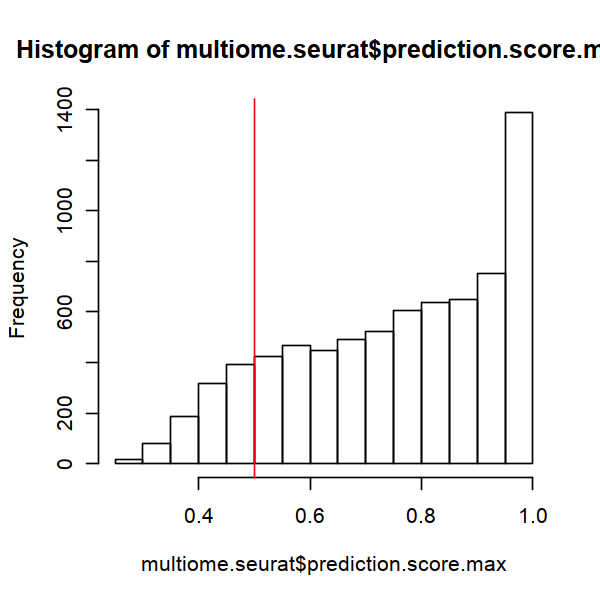

In [29]:
options(repr.plot.width = 5, repr.plot.height = 5)

hist(multiome.seurat$prediction.score.max)
abline(v = 0.5, col = "red")

In [30]:
plot_dimred <- function(x, y, col, dimred="UMAP", subset=NULL, sz=1) {
    plot_df <- data.frame(x=x, y=y,
                 cluster=col)
    plot_df = plot_df[sample(dim(plot_df)[1]), ]
    
    if (!is.null(subset)) {
        plot_df = plot_df[plot_df$cluster==subset, ]
    }
    
    ggplot(plot_df) +
    geom_point(aes(x=x, y=y, color=cluster), stroke=0, size=sz) +
    theme_classic() +
    xlab(sprintf("%s 1", dimred)) + ylab(sprintf("%s 2", dimred)) +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    guides(colour = guide_legend(title="Day",
         override.aes = list(shape=16, alpha=1, size=4))) + coord_fixed()
}

In [31]:
rev(sort(table(multiome.seurat$predicted.id[multiome_metadata$sample=="D2M"])))


   3   13   11   15    2 
1767  824  808  740   22 

In [32]:
rev(sort(table(multiome.seurat$predicted.id[multiome_metadata$sample=="D1M"])))


   3   11   13   15    2 
1375  755  605  476    6 

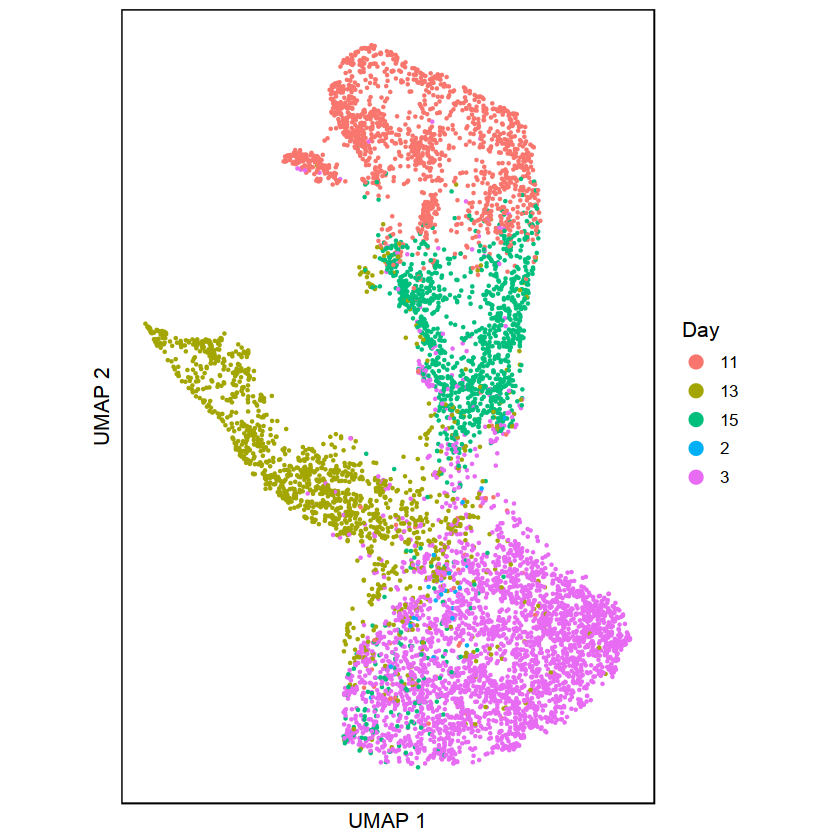

In [33]:
options(repr.plot.width = 7, repr.plot.height = 7)

plot_dimred(data.frame(Embeddings(multiome.seurat, reduction='umap'))$umap_1,
            data.frame(Embeddings(multiome.seurat, reduction='umap'))$umap_2,
            factor(multiome.seurat$predicted.id)) 
# scale_color_manual(values=as.character(cluster_config$colour)[order(cluster_config$new_cluster)]) 

In [34]:
rev(sort(table(multiome.seurat$predicted.id[multiome_metadata$sample=="D1M"])))


   3   11   13   15    2 
1375  755  605  476    6 

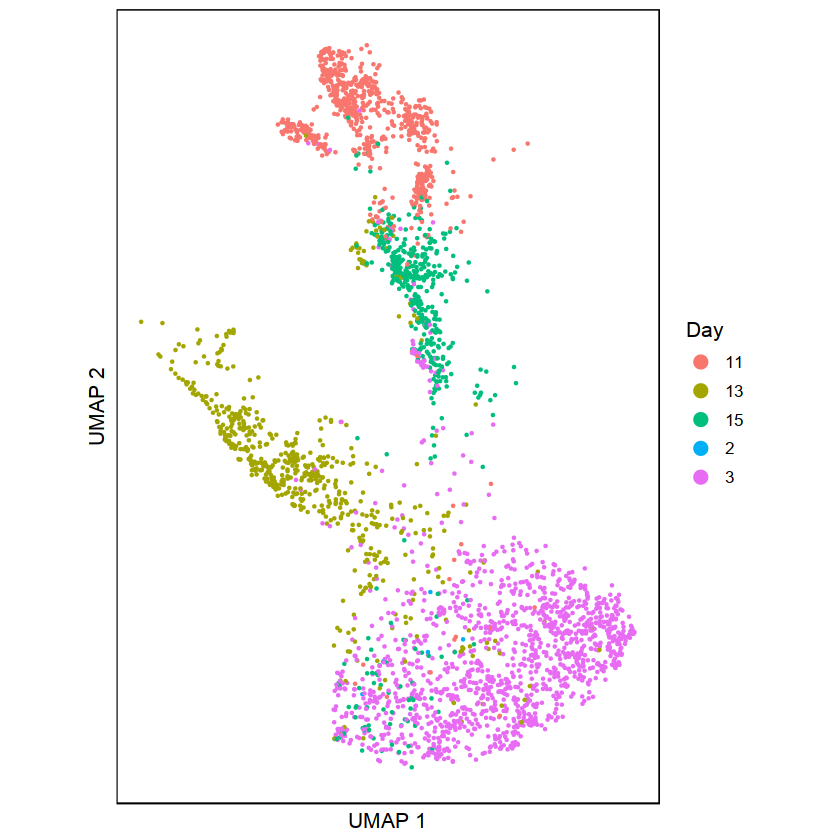

In [35]:
options(repr.plot.width = 7, repr.plot.height = 7)

plot_dimred(data.frame(Embeddings(multiome.seurat, reduction='umap'))$umap_1[multiome_metadata$sample=="D1M"],
            data.frame(Embeddings(multiome.seurat, reduction='umap'))$umap_2[multiome_metadata$sample=="D1M"],
            factor(multiome.seurat$predicted.id[multiome_metadata$sample=="D1M"])) 
# scale_fill_manual(values=as.character(cluster_config$colour)[order(cluster_config$new_cluster)]) 

In [36]:
mod_clst = multiome.seurat$predicted.id
mod_clst[(multiome_metadata$sample=="D1M")&(multiome.seurat$predicted.id==15)] = '4'
mod_clst[(multiome_metadata$sample=="D1M")&(multiome.seurat$predicted.id==11)] = '8'

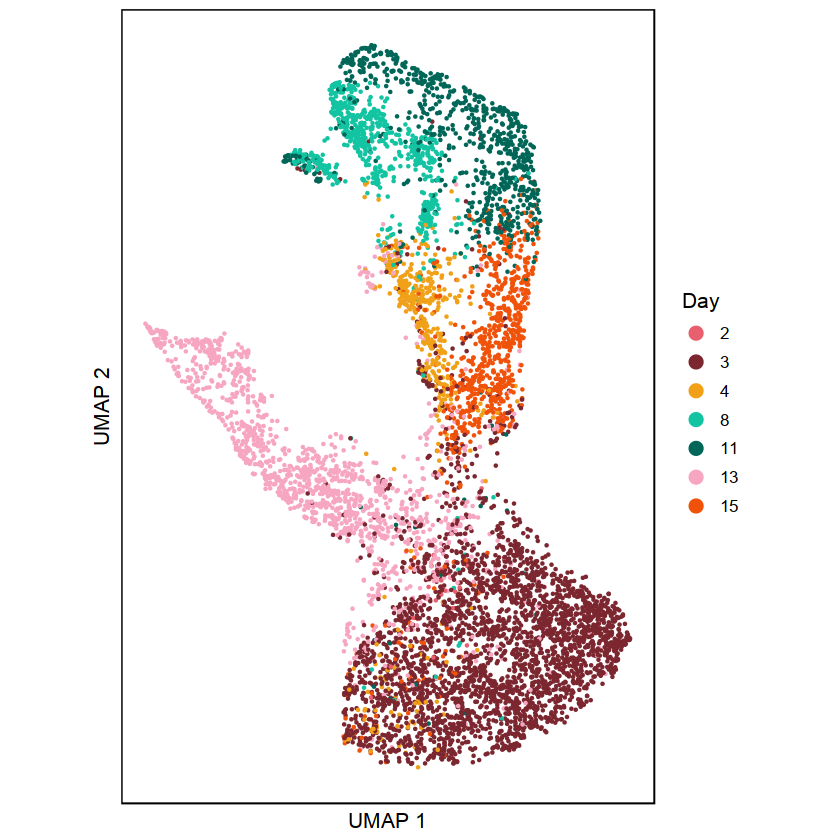

In [37]:
options(repr.plot.width = 7, repr.plot.height = 7)

plot_dimred(data.frame(Embeddings(multiome.seurat, reduction='umap'))$umap_1,
            data.frame(Embeddings(multiome.seurat, reduction='umap'))$umap_2,
            factor(as.numeric(mod_clst))) + 
scale_color_manual(values=as.character(cluster_config$colour)[sort(unique(as.numeric(mod_clst)))])  

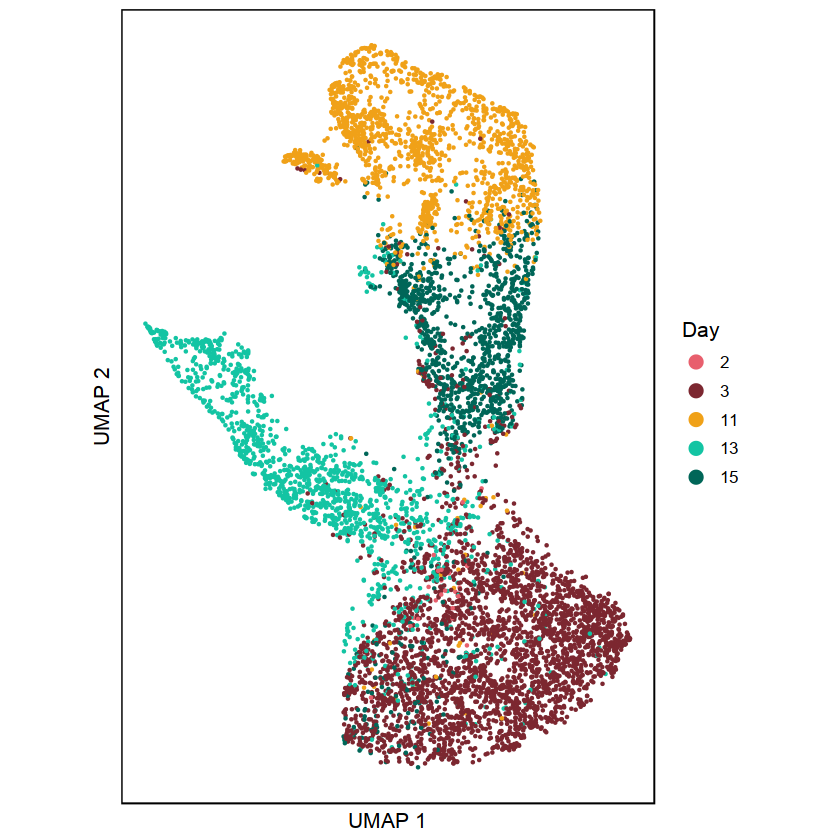

In [38]:
options(repr.plot.width = 7, repr.plot.height = 7)

plot_dimred(data.frame(Embeddings(multiome.seurat, reduction='umap'))$umap_1,
            data.frame(Embeddings(multiome.seurat, reduction='umap'))$umap_2,
            factor(as.numeric(multiome.seurat$predicted.id))) + 
scale_color_manual(values=as.character(cluster_config$colour)[sort(unique(as.numeric(mod_clst)))])  

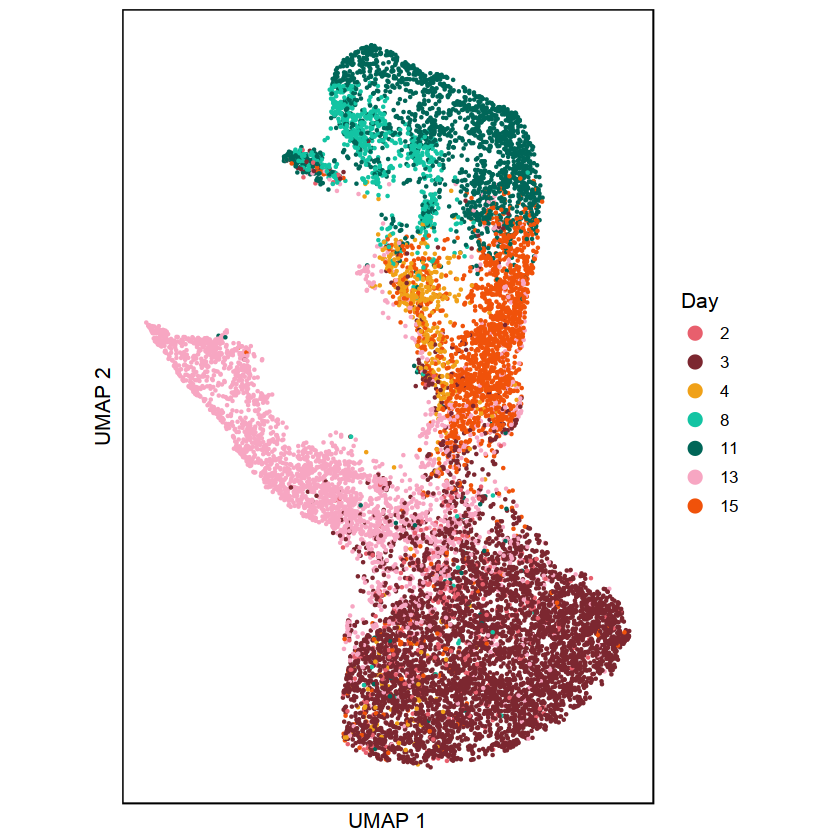

In [40]:
options(repr.plot.width = 7, repr.plot.height = 7)

plot_dimred(c(data.frame(Embeddings(multiome.seurat, reduction='umap'))$umap_1,data.frame(Embeddings(atac.seurat, reduction='umap'))$umap_1),
            c(data.frame(Embeddings(multiome.seurat, reduction='umap'))$umap_2,data.frame(Embeddings(atac.seurat, reduction='umap'))$umap_2),
            factor(as.numeric(c(mod_clst, atac.seurat$orig_cluster)))) + 
scale_color_manual(values=as.character(cluster_config$colour)[sort(unique(as.numeric(mod_clst)))])  

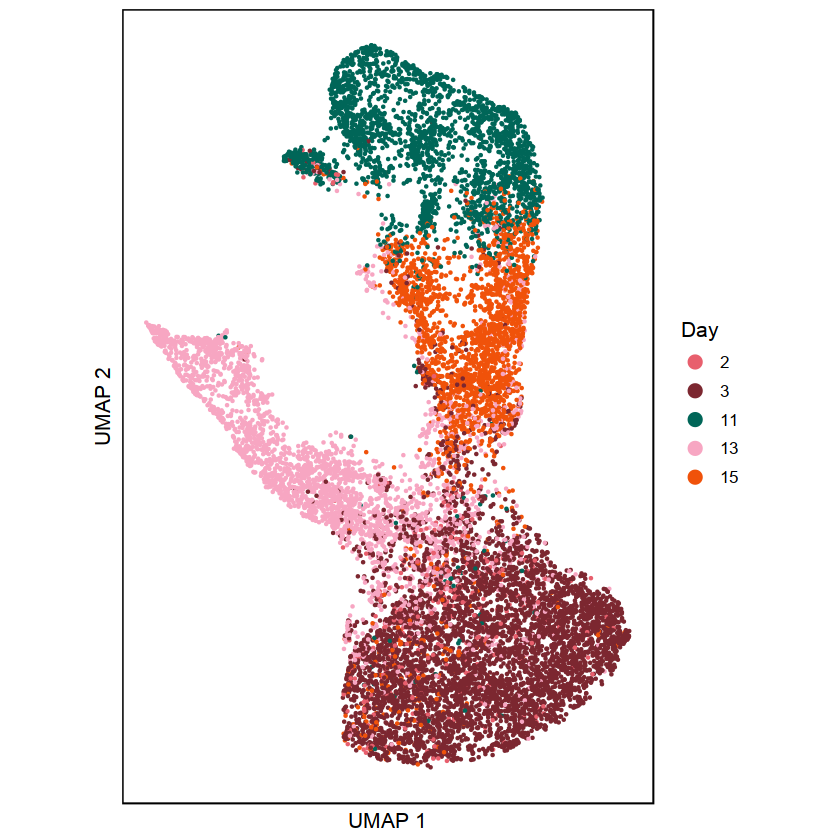

In [43]:
options(repr.plot.width = 7, repr.plot.height = 7)

plot_dimred(c(data.frame(Embeddings(multiome.seurat, reduction='umap'))$umap_1,data.frame(Embeddings(atac.seurat, reduction='umap'))$umap_1),
            c(data.frame(Embeddings(multiome.seurat, reduction='umap'))$umap_2,data.frame(Embeddings(atac.seurat, reduction='umap'))$umap_2),
            factor(c(as.numeric(multiome.seurat$predicted.id), as.numeric(atac.seurat$orig_cluster)))) + 
scale_color_manual(values=as.character(cluster_config$colour)[sort(unique(as.numeric(atac.seurat$orig_cluster)))])  

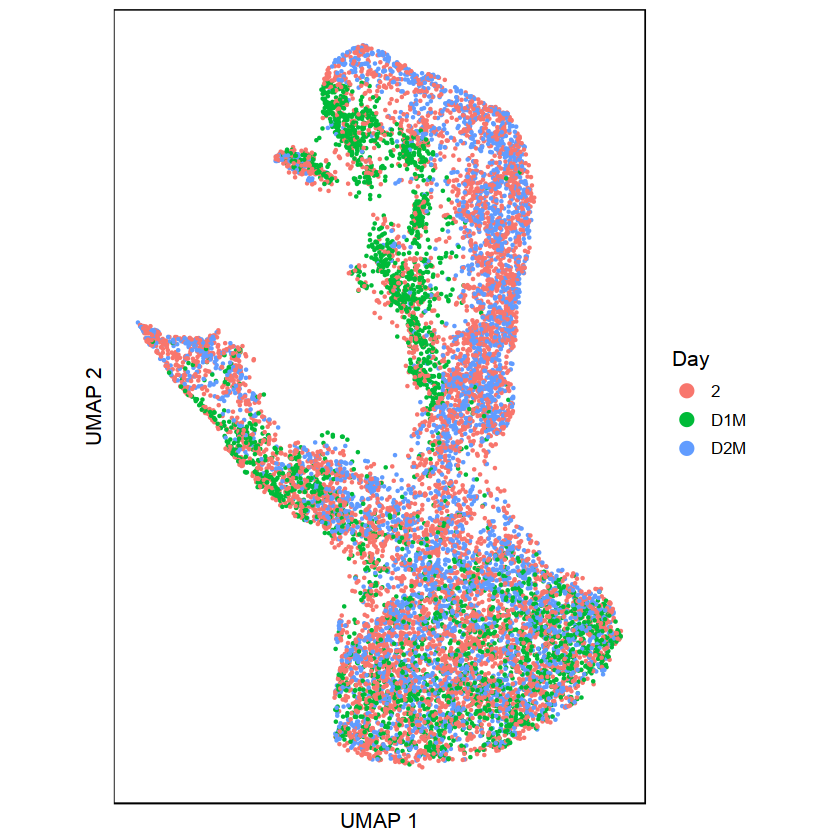

In [59]:
options(repr.plot.width = 7, repr.plot.height = 7)

plot_dimred(c(data.frame(Embeddings(multiome.seurat, reduction='umap'))$umap_1,data.frame(Embeddings(atac.seurat, reduction='umap'))$umap_1),
            c(data.frame(Embeddings(multiome.seurat, reduction='umap'))$umap_2,data.frame(Embeddings(atac.seurat, reduction='umap'))$umap_2),
            factor(c(multiome.seurat$sample, atac.seurat$sample))) 
# scale_color_manual(values=as.character(cluster_config$colour)[sort(unique(as.numeric(atac.seurat$orig_cluster)))])  

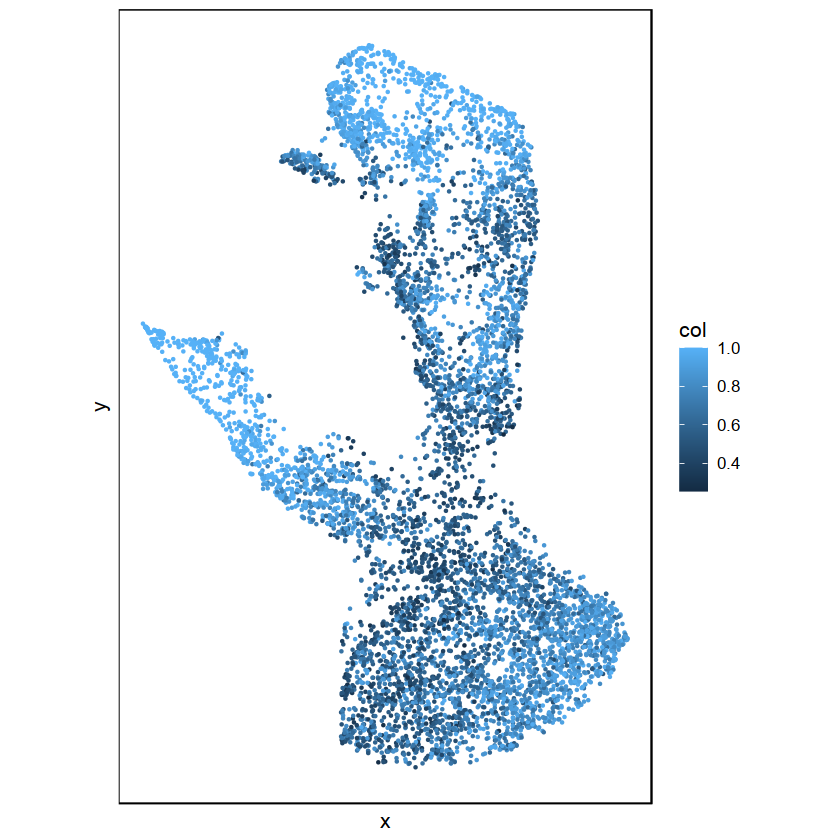

In [44]:
options(repr.plot.width = 7, repr.plot.height = 7)
plot_df = data.frame(x=data.frame(Embeddings(multiome.seurat, reduction='umap'))$umap_1,
            y=data.frame(Embeddings(multiome.seurat, reduction='umap'))$umap_2,
            col=multiome.seurat$prediction.score.max)

ggplot(plot_df) +
    geom_point(aes(x=x, y=y, color=col), stroke=0, size=1) +
    theme_classic() +
#     xlab(sprintf("%s 1", dimred)) + ylab(sprintf("%s 2", dimred)) +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
coord_fixed()

In [49]:
scatac_metadata$transfered_cluster = atac.seurat$orig_cluster
scatac_metadata$orig_cluster = NULL
multiome_metadata$transfered_cluster = multiome.seurat$predicted.id

In [51]:
metaData_w_transfer = rbind(multiome_metadata, scatac_metadata)

In [53]:
table(metaData_w_transfer$transfered_cluster)


  11   13   15    2    3 
2622 2931 2339  369 5264 

In [52]:
head(metaData_w_transfer)

,barcode,TN,UM,PP,UQ,CM,cluster,umap1,umap2,sample,cells,transfered_cluster
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<chr>,<chr>
D1M_AAAAAAAAAAACATGCTATTAGCC,AAAAAAAAAAACATGCTATTAGCC,6736,6736,6736,6729,373,3,-0.4031222,-3.454888,D1M,D1M_AAAAAAAAAAACATGCTATTAGCC,3
D1M_AAAAAAAAAAACATGCTCACCCTC,AAAAAAAAAAACATGCTCACCCTC,28369,28369,28369,28339,2447,5,2.6643078,-3.955240,D1M,D1M_AAAAAAAAAAACATGCTCACCCTC,3
D1M_AAAAAAAAAAACATGCTTGAGAAC,AAAAAAAAAAACATGCTTGAGAAC,28635,28635,28635,28609,2201,1,-0.2071755,2.688192,D1M,D1M_AAAAAAAAAAACATGCTTGAGAAC,15
D1M_AAAAAAAAAAACCATGAACCTTGT,AAAAAAAAAAACCATGAACCTTGT,33869,33869,33869,33838,3018,5,3.1269215,-4.609105,D1M,D1M_AAAAAAAAAAACCATGAACCTTGT,3
D1M_AAAAAAAAAAACCATGAGCTTAAA,AAAAAAAAAAACCATGAGCTTAAA,18885,18885,18885,18867,1514,1,-0.1988264,1.998739,D1M,D1M_AAAAAAAAAAACCATGAGCTTAAA,15
D1M_AAAAAAAAAAACCATGATATAGGC,AAAAAAAAAAACCATGATATAGGC,12385,12385,12385,12370,1282,5,1.7942727,-3.712197,D1M,D1M_AAAAAAAAAAACCATGATATAGGC,3


In [54]:
# write predicted cluster labels (match to old cluster labels)
write.table(metaData_w_transfer,
           "../20220609_Multiome_SnapATAC/sessions/20220612_n13525/metadata.w.transfer.cluster.tsv",
           quote=F,
            sep='\t',
           row.names=F)

---

In [40]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] Seurat_3.1.5                rtracklayer_1.46.0         
 [3] DESeq2_1.26.0               SummarizedExperiment_1.16.1
 [5] DelayedArray_0.12.3         BiocParallel_1.20.1        
 [7] matrixStats_0.56.0          Biobase_2.46.0             
 [9] RColorBrewer_1.1-2        